In [1]:
import sys
sys.path.append('../code')

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch

In [3]:
import read_video as rv
import reconstruction_utils as ru

In [4]:
import Reconstruction_pytorch as rec

In [5]:
filepath = 'D:/mCherryCells/Well1_Every1_2/Well1_Every1_2_holo.avi'

In [6]:
data = rv.read_video(filepath, 0, 10)

In [7]:
data.shape

(10, 1450, 1930)

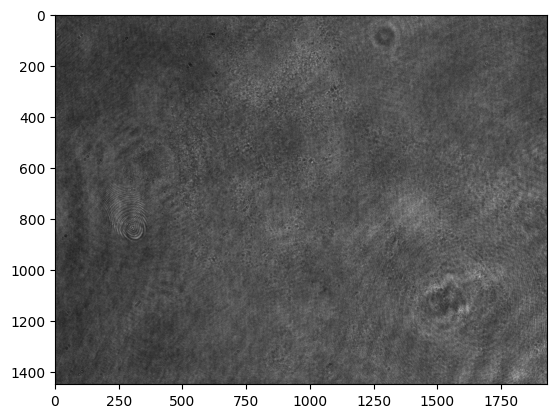

In [8]:
plt.imshow(data[0], cmap='gray')

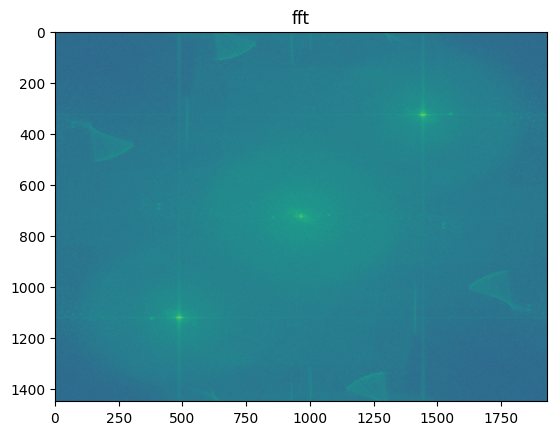

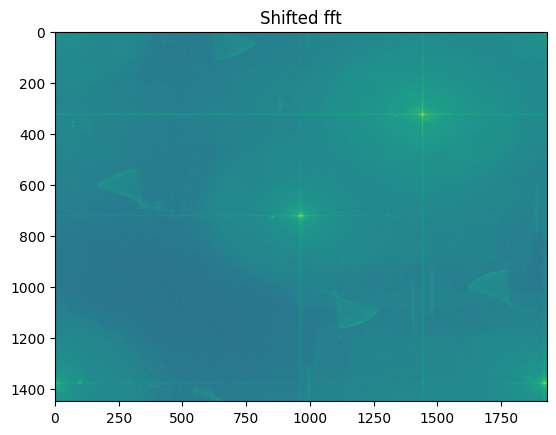

In [9]:
correct_fourier_peak = (0, 0)

frame = data[0]
frame = torch.tensor(frame)

xr, yr = frame.shape

filter_radius = torch.min(torch.tensor([yr, xr])) / 5

X = torch.arange(frame.shape[0]) - frame.shape[0] // 2
Y = torch.arange(frame.shape[1]) - frame.shape[1] // 2
X, Y = torch.meshgrid(X, Y, indexing='ij')
position_matrix = torch.sqrt((X)**2 + Y**2)

kx = torch.linspace(-torch.pi, torch.pi, xr) 
ky = torch.linspace(-torch.pi, torch.pi, yr)
KX, KY = torch.meshgrid(kx, ky, indexing='ij')

# Initialize FourierPeakFinder
finder = ru.FourierPeakFinder(position_matrix, filter_radius, correct_fourier_peak, KX, KY, X, Y)

# Find peak coordinates in Fourier space
kx_add_ky, dist_peak = finder.find_peak_coordinates(frame)

shifted_fft = torch.fft.fftshift(
    torch.fft.fft2(frame * torch.exp(1j*kx_add_ky))
    )

plt.figure()
plt.title("fft")
plt.imshow(torch.log(torch.abs(torch.fft.fftshift(torch.fft.fft2(frame)))))

plt.figure()
plt.title("Shifted fft")
plt.imshow(torch.log(torch.abs(shifted_fft)))

In [10]:
fftImage = torch.fft.fftshift(torch.fft.fft2(frame))

In [11]:
fftImage = torch.where(position_matrix < filter_radius, torch.tensor(0, dtype=fftImage.dtype, device=fftImage.device), fftImage)
#Set fftImage to zero from 0 to middle of the image
fftImage[:, :yr//2] = 0


fftImage = torch.abs(fftImage)

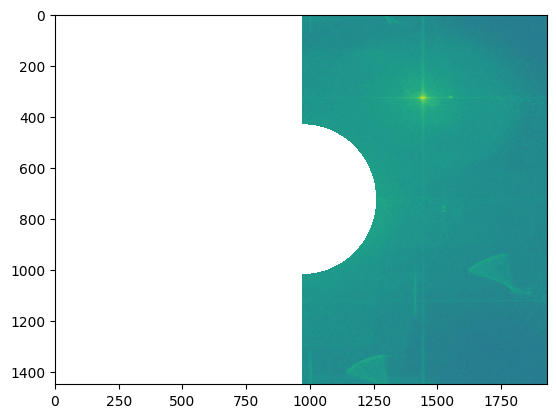

In [12]:
plt.imshow(torch.log(fftImage))

In [13]:
# Compute magnitude of the fftImage
import torch.nn.functional as F
# Apply Gaussian filter to the fftImage
fftImage = F.conv2d(fftImage.real.unsqueeze(0).unsqueeze(0), torch.ones(1, 1, 7, 7, device=fftImage.device) / 49, padding=1).squeeze()

#Find the coordinates of the maximum values in the fftImage
max_index = torch.argmax(fftImage)
max_coords = torch.unravel_index(max_index, fftImage.shape)
max_coords = (max_coords[0], max_coords[1])

In [14]:
max_coords

(tensor(326), tensor(1441))

In [15]:
# Extract coordinates from X and Y matrices
x_pos = position_matrix[max_coords]
y_pos = position_matrix[max_coords]
dist_peak = torch.sqrt(x_pos**2 + y_pos**2)

# Assuming KX and KY are defined similarly to X and Y
kx_pos = KX[max_coords]
ky_pos = KY[max_coords]

# Compute kx_add_ky
kx_add_ky = kx_pos * X + ky_pos * Y

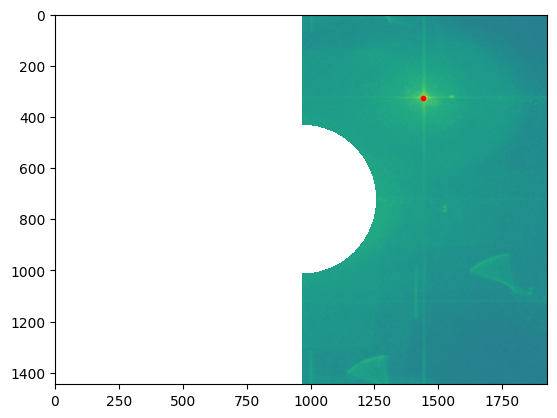

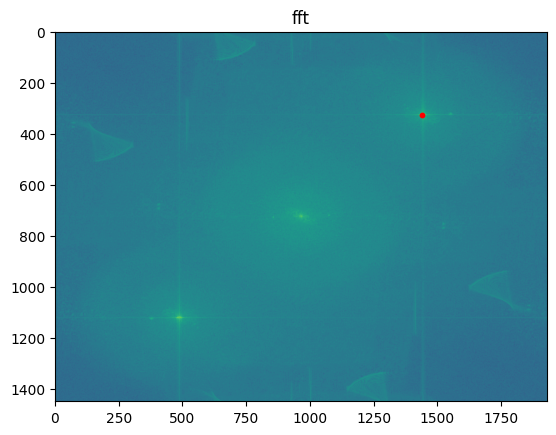

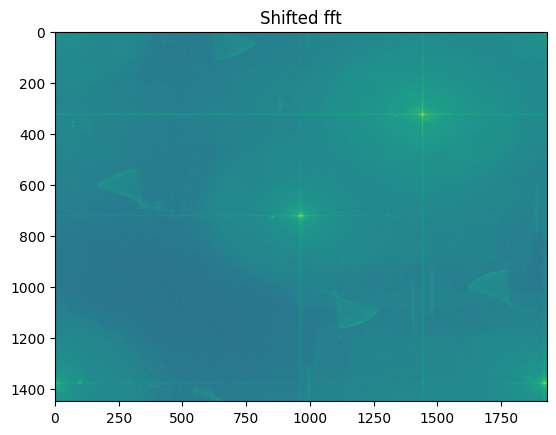

In [16]:
#Visualize where the peak is in the Fourier space

plt.figure()
plt.imshow(torch.log(torch.abs(fftImage)))
plt.scatter(max_coords[1], max_coords[0], color='r', s=10)

#Make so that the peak is in the center of the Fourier space
shifted_fft = torch.fft.fftshift(
    torch.fft.fft2(frame * torch.exp(1j*kx_add_ky))
    )

plt.figure()
plt.title("fft")
plt.imshow(torch.log(torch.abs(torch.fft.fftshift(torch.fft.fft2(frame)))))
plt.scatter(max_coords[1], max_coords[0], color='r', s=10)

plt.figure()
plt.title("Shifted fft")
plt.imshow(torch.log(torch.abs(shifted_fft)))



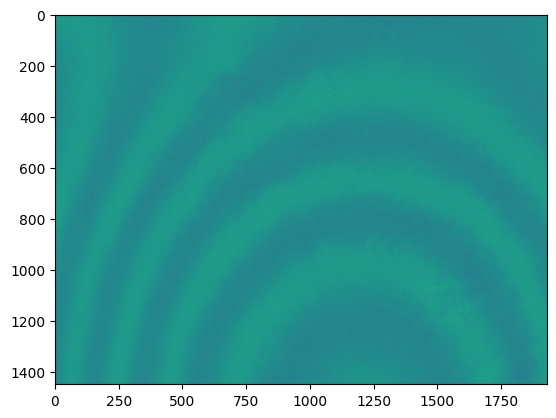

In [17]:
plt.imshow(torch.fft.ifft2(torch.fft.fftshift(shifted_fft)).imag)

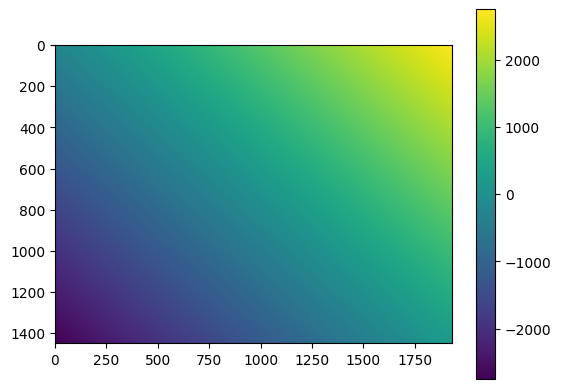

In [18]:
plt.imshow(kx_add_ky)
plt.colorbar()

In [19]:
co = rec.HolographicReconstruction()
co.first_image = frame

In [20]:
co.precalculations()

In [21]:
data = torch.tensor(data).to('cuda')

In [22]:
datan = co.forward(data)

Reconstructing 10 holograms.


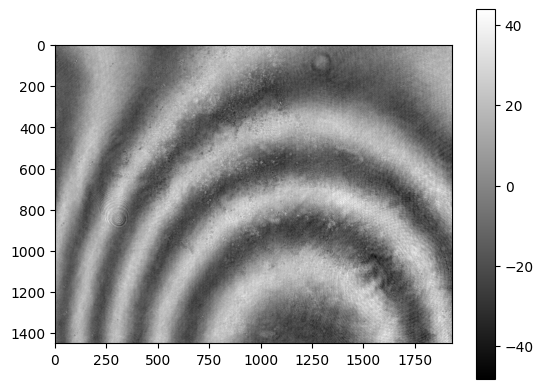

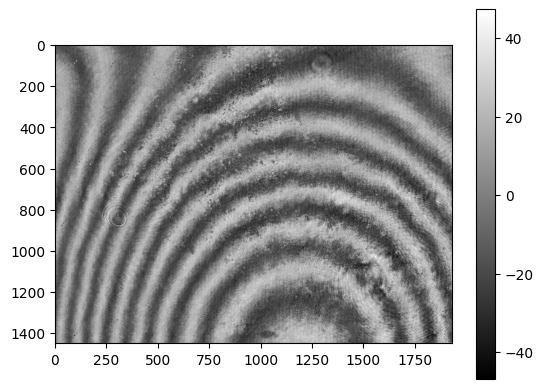

In [23]:
plt.imshow(co.first_field.real.cpu().numpy(), cmap='gray')
plt.colorbar()
plt.figure()
plt.imshow(co.first_field_corrected.real.cpu().numpy(), cmap='gray')
plt.colorbar()

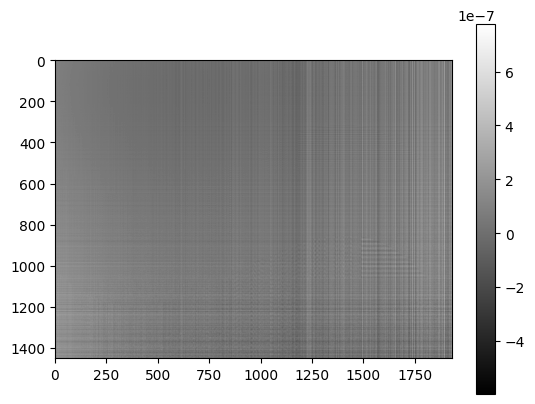

In [24]:
plt.figure()
plt.imshow(co.phase_background.real.cpu().numpy(), cmap='gray')
plt.colorbar()

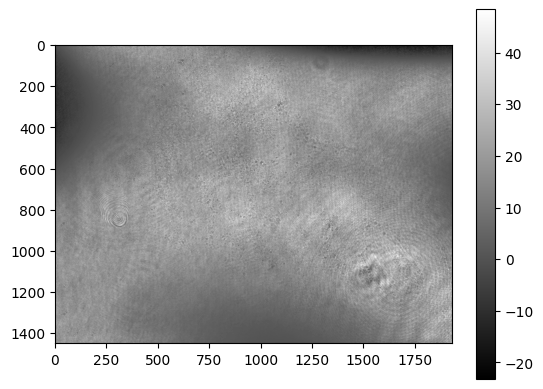

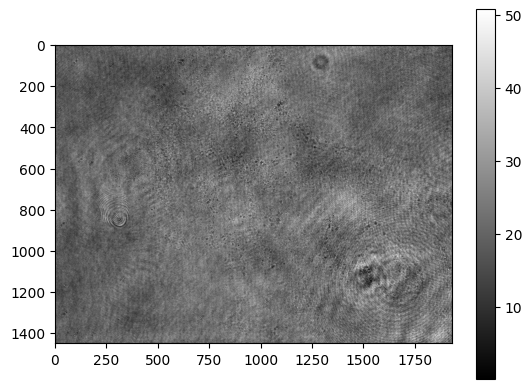

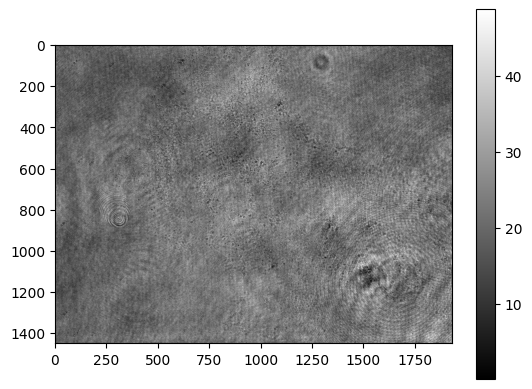

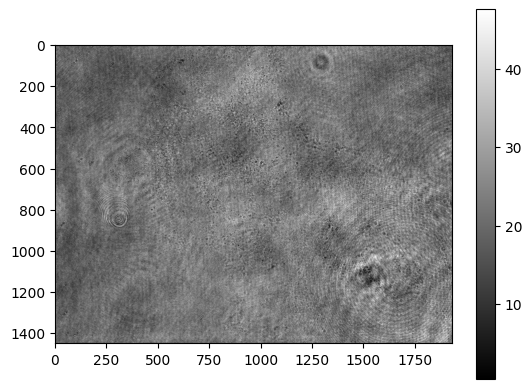

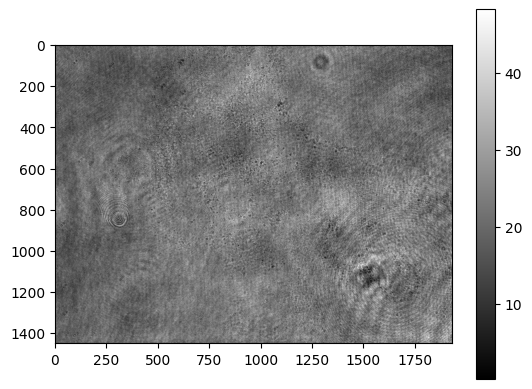

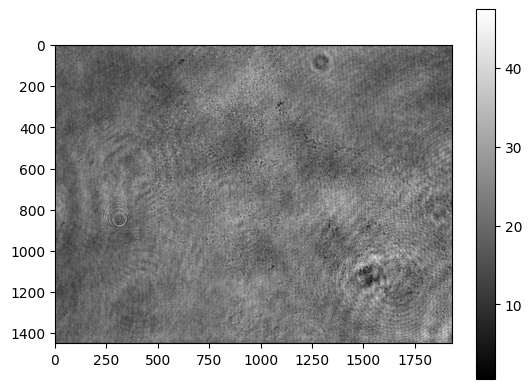

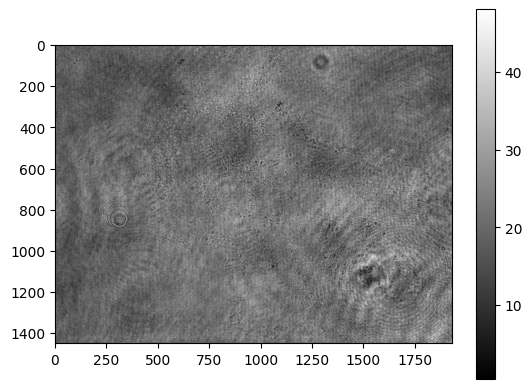

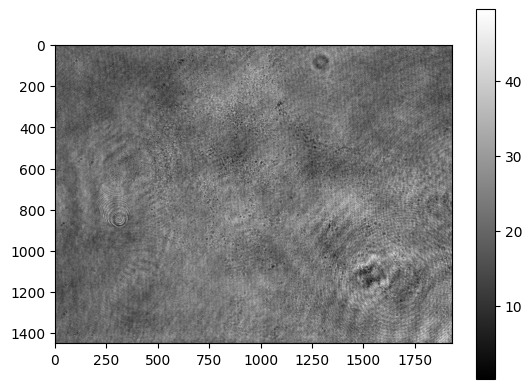

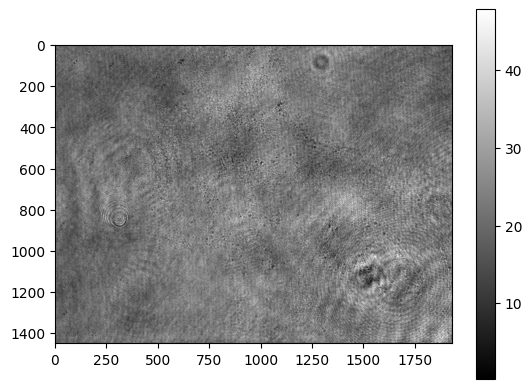

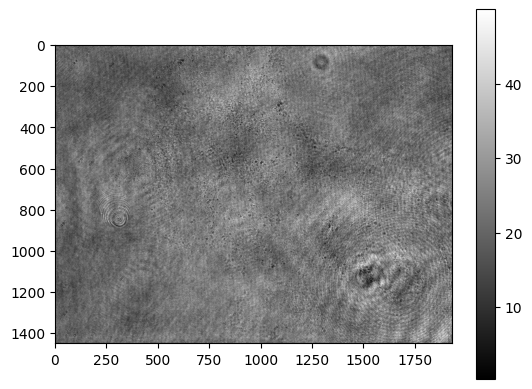

In [26]:
for d in datan:
    plt.figure()
    plt.imshow(d.cpu().real, cmap='gray')
    plt.colorbar()